In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt

import os
import shutil
from collections import OrderedDict



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

# Loading data

**Let's see what the data in the pandas table looks like**

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    transforms.RandomAdjustSharpness(2, p=1),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAdjustSharpness(2, p=1),
    transforms.ToTensor()
    ])

# import data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=train_transform)

test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=test_transform)

train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set) * 0.8), int(len(train_set) * 0.2)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                        batch_size = 100,
                                        shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                        batch_size = 100)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}

#for normalization
dataset_sizes_for_norm = {'train': len(train_set), 'val': len(val_set)}
loaders_for_norm = {
    'train': DataLoader(train_set, batch_size=100, shuffle = True, num_workers=4),
    'val': DataLoader(val_set, batch_size=100, shuffle = True, num_workers=4)
}

#show
dataset_sizes, dataset_sizes_for_norm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


({'train': 48000, 'val': 12000}, {'train': 48000, 'val': 12000})

In [5]:
# for x in ['train', 'val']:
   
#   #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
#   num_pxl = dataset_sizes_for_norm[x]*28*28
    
#   #we go through the butches and sum up the pixels of the objects, 
#   #which then divide the sum by the number of all pixels to calculate the average
#   total_sum = 0
#   for batch in loaders_for_norm[x]: total_sum += batch[0].sum()
#   mean = total_sum / num_pxl

#     #we calculate the standard deviation using the formula that I indicated above
#   sum_sqrt = 0
#   for batch in loaders_for_norm[x]: sum_sqrt += ((batch[0] - mean).pow(2)).sum()
#   std = torch.sqrt(sum_sqrt / num_pxl)

#   # print(f'{x} - mean: {mean}, std: {std}')

**Let's see what the images look like**

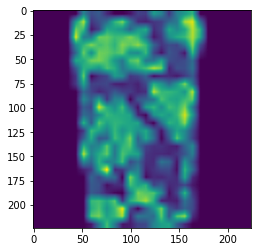

In [7]:
i = np.random.randint(50)
x, y = next(iter(train_dataloader))
plt.imshow(x[i].view(224,224))

# Model

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

In [10]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

**Loss function, Optimizer, Scheduler**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

# Train

In [12]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss))
      accuracies[phase].append(float(epoch_acc))
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

**Launching training**

In [13]:
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.641951852850616, accuracy0.7664375
val - loss:3.037569038073222, accuracy0.32941666666666664
Time: 5.0m 21.061182737350464s
Epoch: 2/10
train - loss:0.3853612935791413, accuracy0.8625833333333333
val - loss:0.45100937969982624, accuracy0.8422499999999999
Time: 10.0m 42.63133120536804s
Epoch: 3/10
train - loss:0.3314741481716434, accuracy0.8815624999999999
val - loss:0.29026100374758246, accuracy0.8924166666666666
Time: 16.0m 4.861374616622925s
Epoch: 4/10
train - loss:0.29552306231732167, accuracy0.8930625
val - loss:0.28183467003206414, accuracy0.8988333333333333
Time: 21.0m 26.85563373565674s
Epoch: 5/10
train - loss:0.22372268731705844, accuracy0.9186875
val - loss:0.21635361838464937, accuracy0.9219166666666666
Time: 26.0m 48.983023166656494s
Epoch: 6/10
train - loss:0.21013282579369844, accuracy0.9244583333333333
val - loss:0.2132827307097614, accuracy0.9249166666666666
Time: 32.0m 10.870168209075928s
Epoch: 7/10
train - loss:0.20112293343991042, accurac

**Visualization**

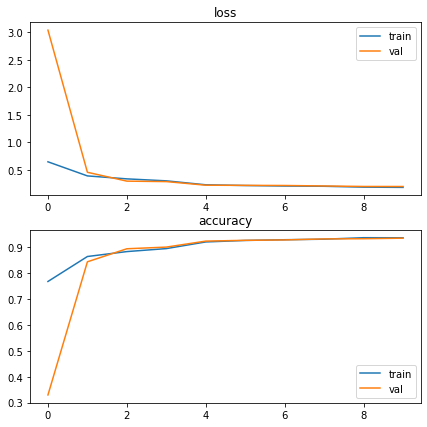

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

# Test

**Uploading the data**

In [15]:
loadersq=  DataLoader(test_set, batch_size=100, shuffle = True, num_workers=4)

**Creating a dictionary with the size of the test dataset.**

In [16]:
dataset_sizesq = len(test_set)
dataset_sizesq

10000

**Similarly, we calculate the average and standard deviation for test**

In [17]:
# num_px = dataset_sizesq*28*28


# total_sum = 0
# for batch in loadersq: total_sum += batch[0].sum()
# mean = total_sum / num_px

# sum_of_squared_error = 0
# for batch in loadersq: sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
# std = torch.sqrt(sum_of_squared_error / num_px)

# mean, std

**Predictions**

In [18]:
corr = 0
 
with torch.no_grad(): 
    for data in loadersq:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images) 
        _, predicted = torch.max(y_pred, 1) 
        corr += torch.sum(predicted == labels.data)
 
print(f"Test accuracy: {corr/dataset_sizesq}")

Test accuracy: 0.9223999977111816


In [19]:
from torch.autograd import Variable

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in loadersq:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 86.10%
Accuracy of Trouser: 97.90%
Accuracy of Pullover: 89.90%
Accuracy of Dress: 92.30%
Accuracy of Coat: 88.20%
Accuracy of Sandal: 98.40%
Accuracy of Shirt: 77.90%
Accuracy of Sneaker: 96.80%
Accuracy of Bag: 98.60%
Accuracy of Ankle Boot: 96.30%


## Predict with Jury Test

In [20]:
# def resize_image(src_image, size=(128,128), bg_color='white'): 
#     from PIL import Image, ImageOps 
    
#     # resize the image so the longest dimension matches our target size
#     src_image.thumbnail(size, Image.ANTIALIAS)
    
#     # Create a new square background image
#     new_image = Image.new("RGB", size, bg_color)
    
#     # Paste the resized image into the center of the square background
#     new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
#     # return the resized image
#     new_image = Image.open(src_image).convert('L')
#     return new_image

In [21]:
import numpy as np
import cv2

def resize_to_28x28(img):
    img_h, img_w = img.shape
    dim_size_max = max(img.shape)

    if dim_size_max == img_w:
        im_h = (26 * img_h) // img_w
        if im_h <= 0 or img_w <= 0:
            print("Invalid Image Dimention: ", im_h, img_w, img_h)
        tmp_img = cv2.resize(img, (26,im_h),0,0,cv2.INTER_NEAREST)
    else:
        im_w = (26 * img_w) // img_h
        if im_w <= 0 or img_h <= 0:
            print("Invalid Image Dimention: ", im_w, img_w, img_h)
        tmp_img = cv2.resize(img, (im_w, 26),0,0,cv2.INTER_NEAREST)

    out_img = np.zeros((28, 28), dtype=np.ubyte)

    nb_h, nb_w = out_img.shape
    na_h, na_w = tmp_img.shape
    y_min = (nb_w) // 2 - (na_w // 2)
    y_max = y_min + na_w
    x_min = (nb_h) // 2 - (na_h // 2)
    x_max = x_min + na_h

    out_img[x_min:x_max, y_min:y_max] = tmp_img

    return out_img


In [22]:
import torchvision.transforms.functional as F
# Show Function for image tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import torchvision.transforms as T

def pre_image(image_path,model):
   #img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
   #img = resize_to_28x28(img)
   #img = cv.bitwise_not(img)
   img = Image.open(image_path).convert('L')
  #  display(img)
   transform_norm = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.RandomAdjustSharpness(2, p=1),
       transforms.ToTensor()
       ])
   # get normalized image
   img_normalized = transform_norm(img).float()
   show(img_normalized)
   img_normalized = img_normalized.unsqueeze_(0)
   # Show image after transform
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = ['T-shirt/Top','Trouser','PullOver','Dress','Coat','Sandal','Shirt', 'Sneaker','Bag','Ankle Bot']
      class_name = classes[index]
      return class_name

Saving mnist_35_bag.png to mnist_35_bag.png
Bag


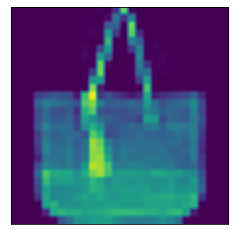

In [36]:
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  predict_class = pre_image(fn,model)
  print(predict_class)

## Save Model

In [25]:
# model.cpu()
torch.save({'arch': 'vgg',
            'state_dict': model.state_dict()},
            'classifier.pth')

Saving sandal_1.jpeg to sandal_1.jpeg


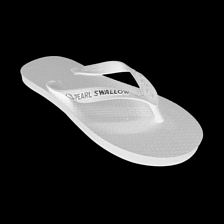

In [40]:
import torchvision.transforms as T
from PIL import Image
 
# invert the colors with probability=1
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomInvert(p=1),
    transforms.Resize((224,224)),
    transforms.RandomAdjustSharpness(2, p=1)
    ])

%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  # read image from your computer
  img = Image.open(path)

  img = transform(img)
  display(img)